In [1]:
# to plot the rectangles
import matplotlib.pyplot as plt
# to parse the text file
import re
# to store the data as a dataframe
import pandas as pd
#  type hinting for the function
from typing import Optional, List, Tuple, Set
# default dictionary to store rectangles
from collections import defaultdict

import numpy as np
import graphviz as gv
import random 
import matplotlib.colors as mcolors
from enum import Enum


In [2]:
input1 = './input_1.txt'
input2 = './input_2.txt'

In [3]:
class FloorPlan:
    class Block:
        def __init__(self,block_id: int, width: int, height: int, label: str = None):
            self.label = label or f'block_{block_id}'
            self.block_id = block_id
            self.width = width
            self.height = height

        def __str__(self):
            return f'label: {self.label}, width: {self.width}, height: {self.height}, idx: {self.block_id}'
        
        def __repr__(self):
            return self.__str__()

    def __init__(self,input1,input2):
        with open(input1, 'r') as file:
            input1_data = file.read()

        with open(input2, 'r') as file:
            input2_data = file.read()
        
        input1_data = eval(input1_data.replace(' ', '').replace('\n', '').replace('{', '(').replace('}', ')'))
        self.adjM = np.array([eval('['+row.strip().replace(' ', ',')+']')for row in input2_data.strip()[1:-1].split('\n')])
        
        self.num_blocks = input1_data[0]
        self.blocks = [FloorPlan.Block(idx, width, height) for idx, (width, height) in enumerate(input1_data[1:])]

    def __repr__(self):
        return f'num_blocks: {self.num_blocks}, blocks: {self.blocks}'
    
    def __str__(self):
        return f'num_blocks: {self.num_blocks}, blocks: {self.blocks}'
    
    @staticmethod
    def get_color(block_id):
        # Create a random color based on the block_id
        random.seed(block_id)
        r, g, b = random.random(), random.random(), random.random()
        color_str = mcolors.rgb2hex((r, g, b))
        return color_str
    
    def plot_floor_plan(self):
        graph = gv.Graph(node_attr={'shape': 'rectangle'})
        # adding nodes
        for block in self.blocks:
            color = self.get_color(block.block_id)
            graph.node(block.label, f'{block.label}\n{block.width}x{block.height}', width=f'{block.width//5}', height=f'{block.height//5}', color=color)
        # adding edges
        for i in range(self.num_blocks):
            for j in range(i+1,self.num_blocks):
                wires_count = self.adjM[i][j]
                color = self.get_color(i)
                graph.edge(self.blocks[i].label,self.blocks[j].label, color=color,label=f'{wires_count}')
        return graph
        

In [4]:
fp = FloorPlan(input1,input2)
fp

num_blocks: 6, blocks: [label: block_0, width: 10, height: 5, idx: 0, label: block_1, width: 8, height: 6, idx: 1, label: block_2, width: 4, height: 13, idx: 2, label: block_3, width: 10, height: 3, idx: 3, label: block_4, width: 8, height: 4, idx: 4, label: block_5, width: 4, height: 1, idx: 5]

In [5]:
fp.adjM

array([[0, 1, 3, 2, 4, 2],
       [1, 0, 3, 1, 2, 1],
       [3, 3, 0, 1, 1, 2],
       [2, 1, 1, 0, 2, 3],
       [4, 2, 1, 2, 0, 1],
       [2, 1, 2, 3, 1, 0]])

In [18]:
with open(input1, 'r') as file:
    input1_data = file.read()
input1_data = eval(input1_data.replace(' ', '').replace('\n', '').replace('{', '(').replace('}', ')'))
input1_data

(6, (10, 5), (8, 6), (4, 13), (10, 3), (8, 4), (4, 1))

In [19]:
area_dict = {idx:width*height for idx, (width, height) in enumerate(input_data1[1:])}
area_dict

{0: 50, 1: 48, 2: 52, 3: 30, 4: 32, 5: 4}

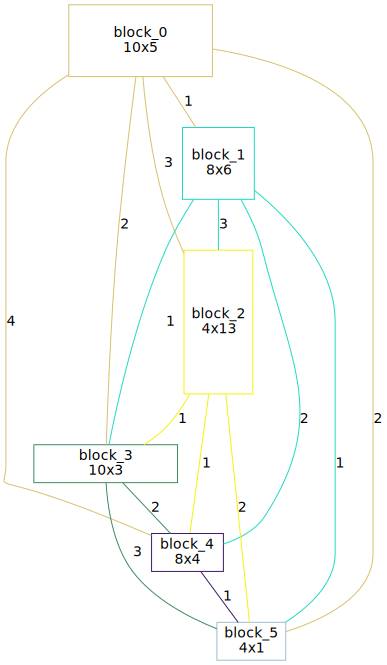

In [5]:
fp.plot_floor_plan()

In [6]:
class PartitionSet(Enum):
    SET_A = 0
    SET_B = -1
    def invert(self):
        self = PartitionSet(~self.value)
        return self


In [7]:
class Net:
    def __init__(self,u: int, v: int, w: int):
        self.u ,self.v = min(u,v), max(u,v)
        self.w = w
        self.cell_list = list()
        self.a_size = None
        self.b_size = None

In [8]:
class Cell:
    def __init__(self, block: FloorPlan.Block):
        self.area = block.width*block.height
        self.external_nets = None
        self.internal_nets = None
        self.gain = None
        self.locked = False
        self.cell_partition = None
        self.adjacent_cells = None
        self.net_list = list()

        


In [9]:
adjM = np.array([[0,2,1,0], [2,0,3,0], [1,3,0,2],[0,0,2,0]])
MAX_GAIN = np.max(np.sum(adjM, axis=1))
MAX_GAIN

6

In [10]:
adjL = defaultdict(list)
for i in range(adjM.shape[0]):
    for j in range(i+1,adjM.shape[1]):
        if adjM[i][j] > 0:
            adjL[i].append((j,adjM[i][j]))
            adjL[j].append((i,adjM[i][j]))
adjL

defaultdict(list,
            {0: [(1, 2), (2, 1)],
             1: [(0, 2), (2, 3)],
             2: [(0, 1), (1, 3), (3, 2)],
             3: [(2, 2)]})

In [11]:
nodes = list(adjL.keys())
nodes

[0, 1, 2, 3]

In [12]:
def random_partition(lst):
    random.seed(3)
    random.shuffle(lst.copy())
    midpoint = len(lst) // 2
    return set(lst[:midpoint]), set(lst[midpoint:])

In [13]:
a,b = random_partition(nodes)
a,b

({0, 1}, {2, 3})

In [14]:
def in_same_set(u,v,a,b):
    return u in a and v in a or u in b and v in b

In [15]:
gain = defaultdict(int)
cut_size = 0
bucket_a = [[] for _ in range(2*MAX_GAIN+1)]
bucket_b = [[] for _ in range(2*MAX_GAIN+1)]
for u in adjL:    
    for v,w in adjL[u]:
        if in_same_set(u,v,a,b):
            gain[u] -= w
        else:
            gain[u] += w
            cut_size += 1
    if u in a:
        bucket_a[gain[u]].append(u)
    else:
        bucket_b[gain[u]].append(u)

In [8]:
adjM = np.array([[0, 1, 3, 2, 4, 2],
                     [1, 0, 3, 1, 2, 1],
                     [3, 3, 0, 1, 1, 2],
                     [2, 1, 1, 0, 2, 3],
                     [4, 2, 1, 2, 0, 1],
                     [2, 1, 2, 3, 1, 0]])

In [12]:
type(adjM[0][0])

numpy.int64

In [ ]:
def get_max_gain(bucket_a,bucket_b,a,b):

    if len(a) == len(b):
    
    max_gain = (-(MAX_GAIN+1),None)
    for cells in bucket:
        if cells:
            


In [33]:
max_gain_a = (-(MAX_GAIN+1),None)
max_gain_b = (-(MAX_GAIN+1),None)

for u,g in enumerate(max_gain_a):
    if g:
         max_gain_a = max(max_gain_a,(gain[u],u)) 
for u,g in enumerate(max_gain_b):
     if g:
        max_gain_b = max(max_gain_b,(gain[u],u))      

max_gain_a,max_gain_b  
          

((-3, 0), (-3, 0))

In [16]:
cut_size

4

In [17]:
gain

defaultdict(int, {0: -1, 1: 1, 2: 2, 3: -2})

In [18]:
bucket_a,bucket_b

([[], [1], [], [], [], [], [], [], [], [], [], [], [0]],
 [[], [], [2], [], [], [], [], [], [], [], [], [3], []])

In [19]:

def get_max_element(max_heap_a, max_heap_b):
    if len(max_heap_a) == len(max_heap_b) and len(max_heap_a)>0:
        max_element_a = (-max_heap_a[0][0],max_heap_a[0][1],'a')
        max_element_b = (-max_heap_b[0][0],max_heap_b[0][1],'b') 
        return max(max_element_a, max_element_b)
    elif max_heap_a and len(max_heap_a) > len(max_heap_b):
        return (-max_heap_a[0][0],max_heap_a[0][1],'a')
    elif max_heap_b and len(max_heap_b) > len(max_heap_a):
        return (-max_heap_b[0][0],max_heap_b[0][1],'b')


In [20]:
max_ele = get_max_element(max_heap_a, max_heap_b)
max_ele

(2, 2, 'b')

In [29]:
def get_comp_set(partition_set):
    return 'b' if partition_set == 'a' else 'a'

In [23]:
u = max_ele[1]
for v,w in adjL[u]:
    old_bucket = eval(f'bucket_{max_ele[0]}')
    new_bucket = eval(f'bucket_{get_comp_set(max_ele[0])}')
    old_bucket[gain[v]].remove(v)
    if in_same_set(u,v,a,b):
        gain[v] += 2*w
    else:
        gain[v] -= 2*w
    new_bucket[gain[v]].append(v)
gain

defaultdict(int, {0: -3, 1: -5, 2: 2, 3: 2})

In [22]:
new_cut_size = cut_size - max_ele[0]
new_cut_size

2

In [24]:
# remove the swapped element
gain.pop(u)
gain

defaultdict(int, {0: -3, 1: -5, 3: 2})

In [25]:
locked_cells = list()
locked_cells.append(max_ele[1])
print('Locked Cells:',locked_cells)

Locked Cells: [2]


In [45]:
# update gains 
u = 
for u in adjL:    
    
    if u in a:
        bucket_a[gain[u]].append(u)
        heapq.heappush(max_heap_a, (-gain[u],u))
        
    else:
        bucket_b[gain[u]].append(u)
        heapq.heappush(max_heap_b,( -gain[u],u))

In [37]:
eval(max_ele[2]).remove(max_ele[1])

In [40]:
if max_ele[2] == 'a':
    b.add(max_ele[1])
elif max_ele[2] == 'b':
    a.add(max_ele[1])

In [41]:
a,b

({0, 1, 2}, {3})

Locked Cells: [2]


defaultdict(int, {0: -1, 1: 1, 3: -2})

In [43]:
# update gains of all the neighbors 
for u in adjL[max_ele[1]]:
    print(u)

(0, 1)
(1, 3)
(3, 2)
